# 1 - Data Exploration

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../')
import src.utils as utils
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor



## a) Load the dataset

We simply use the builtin `read_csv()` method from Pandas to read the CSV file into memory. The result of this operation is a Pandas DataFrame.

We can use `df.info()` to get some metadata about the DataFrame. We can see the amount of rows and columns along with their data types.

In [132]:
url = '../data/StudentsPerformance.csv'
random_state = 42
test_size = 0.2

In [133]:
df = pd.read_csv(url)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


We check out the first rows of the DataFrame by using `df.head()`. We can see from the previous section that there are 5 categorical features and 3 numerical features. Of the three numerical features there are test scores for math, reading and writing. The latter of which we will try to predict in this project.

In [134]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


To get an overview of the dataset's numeric features, we employ `df.describe()`

In [135]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [136]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

We can see that there are no missing value in any of the columns

### II - Check for duplicates

In [137]:
df.duplicated().sum()

0

We can also see that there are no duplicated rows in the DataFrame. 

### III - Check for outliers

There are no outliers in the categorical features. Let us check the numerical ones. We can do this with a box plot from Seaborn.


<Axes: >

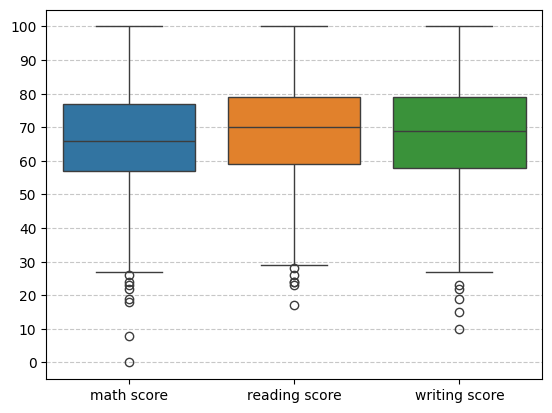

In [138]:
plt.yticks(range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.boxplot(data=df[['math score', 'reading score', 'writing score']])

In [139]:
# Find outliers using IQR method, threshold set to 1.5
df_outliers = pd.concat(
    [
        utils.find_outliers_iqr(df, "math score"),
        utils.find_outliers_iqr(df, "reading score"),
        utils.find_outliers_iqr(df, "writing score"),
    ],
    axis=0,
).drop_duplicates()
print(f"Number of outliers: {df_outliers.shape[0]}")


Number of outliers: 12


There are some outliers in the test scores. Out of 1000 entries 12 seems like a realistic number of outliers, so we keep them in the dataset.

## c) Visualizing distribution of features

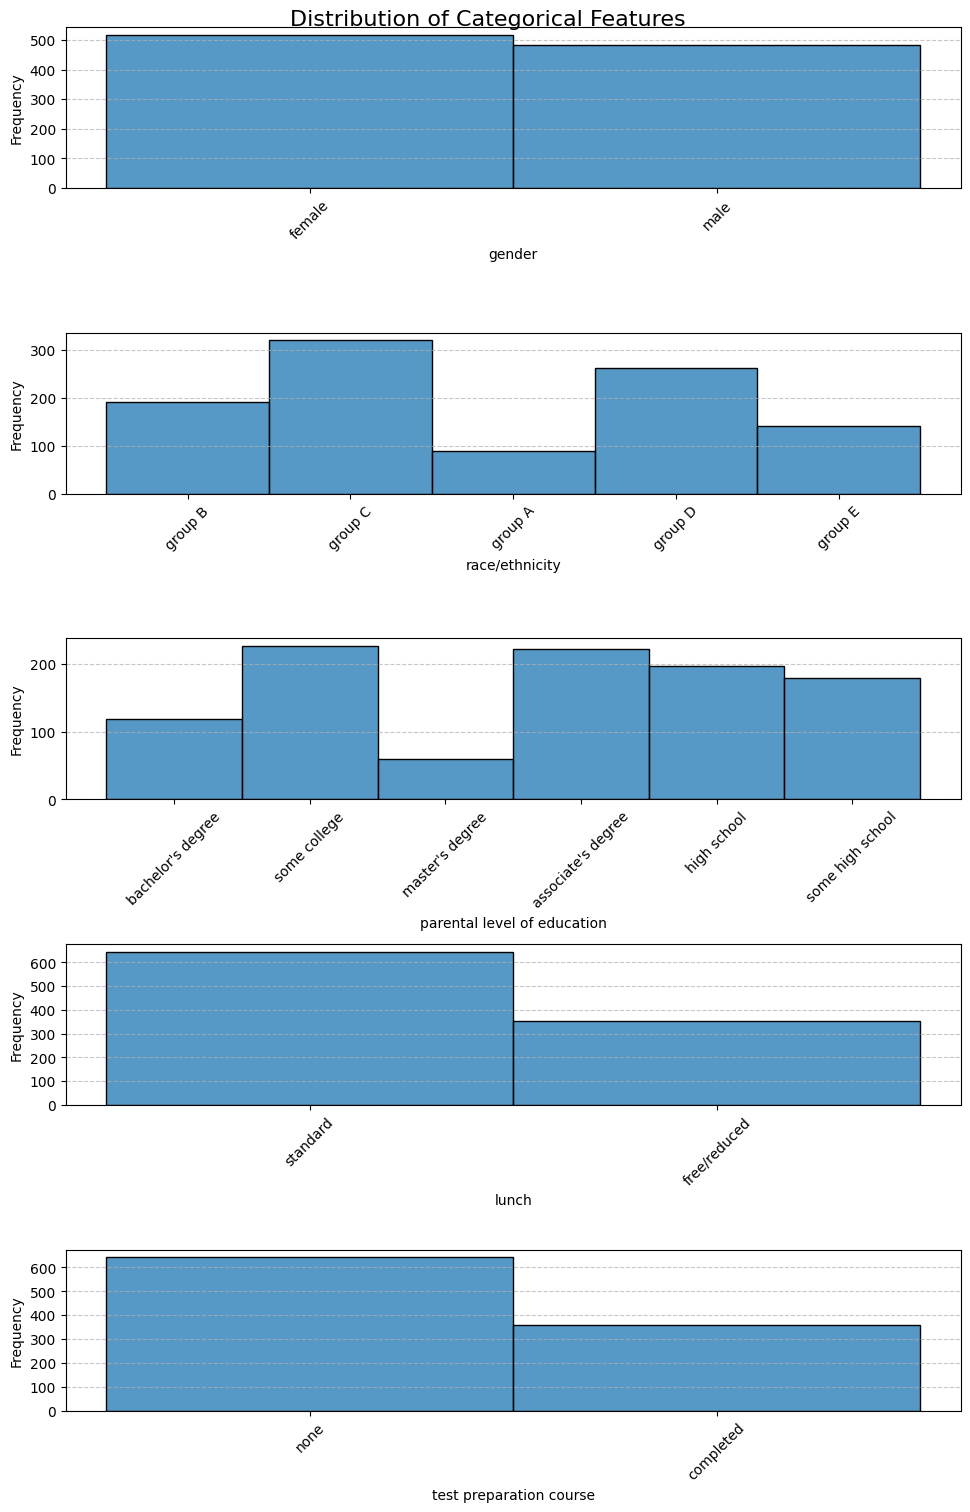

In [140]:
fig, axes = plt.subplots(ncols=1, nrows=len(list(filter(lambda x: "score" not in x, df.columns))), figsize=(10, 15))

fig.suptitle("Distribution of Categorical Features", fontsize=16)
axes = axes.flatten()
for ax, col in zip(axes, filter(lambda x: "score" not in x, df.columns)):
    ax.set_xlabel(col)
    ax.set_yticks(range(0, 1001, 100))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Frequency")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout(pad=1)
    sns.histplot(df[col], ax=ax)

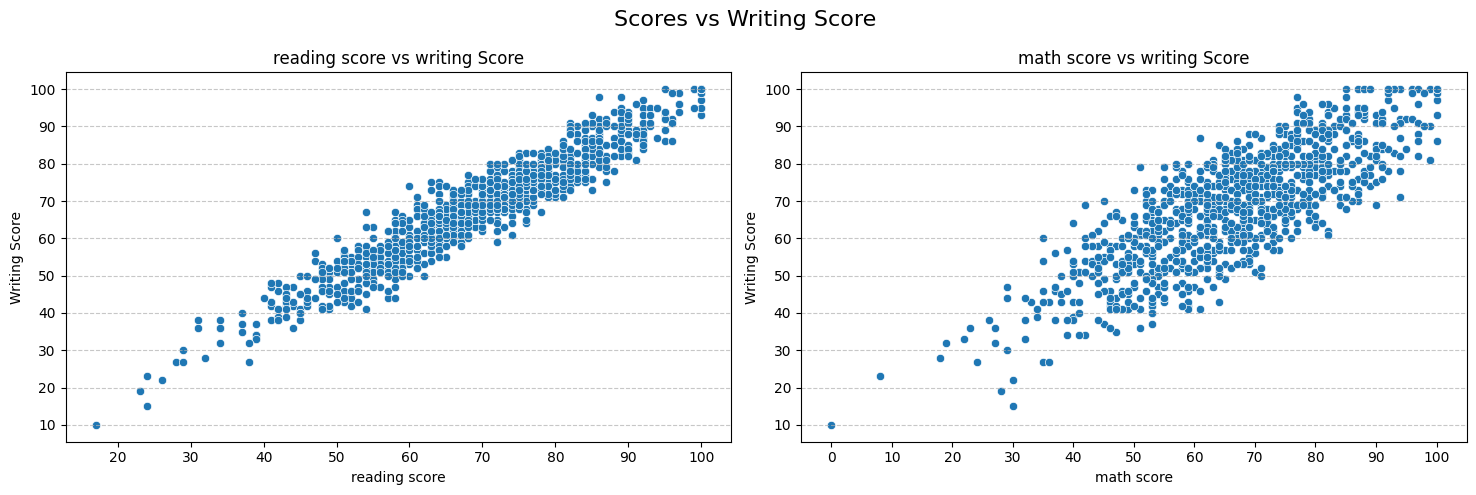

In [141]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.suptitle("Scores vs Writing Score", fontsize=16)
for ax, col in zip(axes, ["reading score", "math score"]):
    ax.set_title(f"{col} vs writing Score")
    ax.set_xlabel(col)
    ax.set_xticks(range(0, 101, 10))
    ax.set_yticks(range(0, 101, 10))
    ax.set_ylabel("Writing Score")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout(w_pad=1)
    sns.scatterplot(data=df, x=col, y="writing score", ax=ax)

<Axes: >

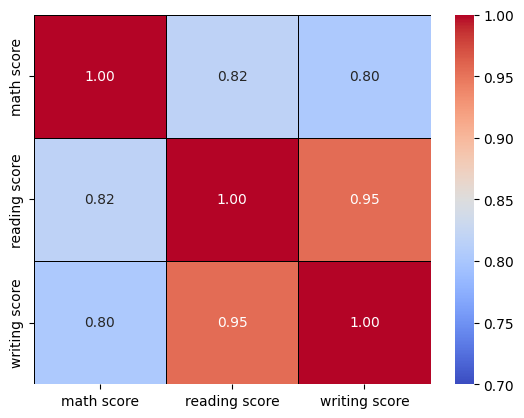

In [142]:
sns.heatmap(
    df[["math score", "reading score", "writing score"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0.7,
    vmax=1,
    linewidths=0.5,
    linecolor='black'
)

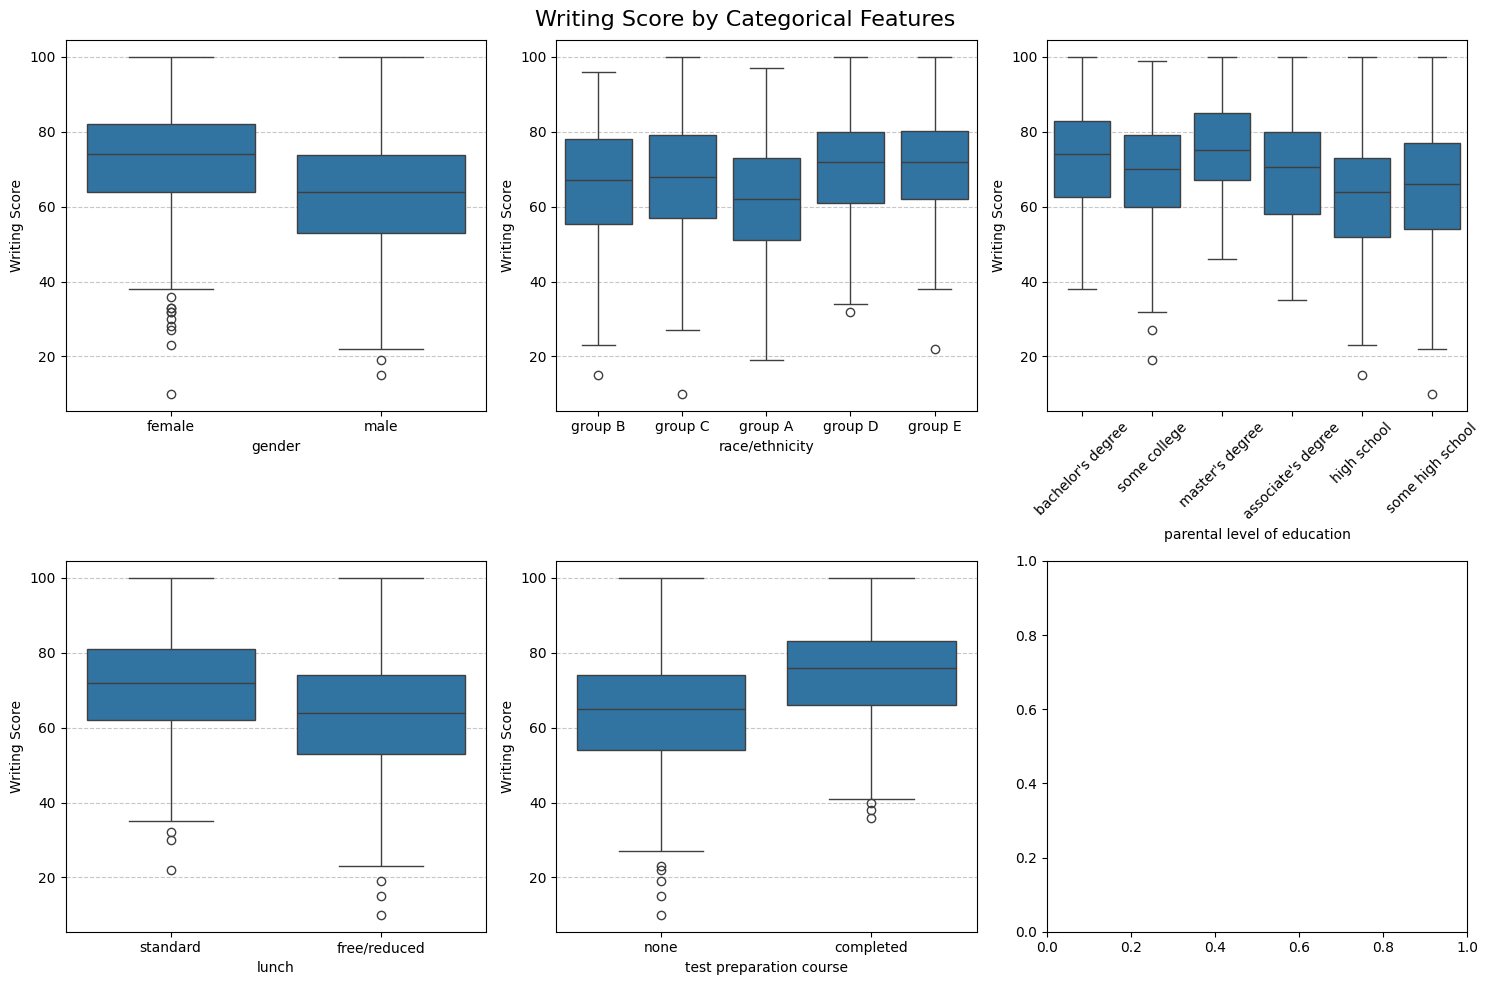

In [143]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

categorical_features = filter(lambda x: "score" not in x, df.columns)
fig.suptitle("Writing Score by Categorical Features", fontsize=16)

for ax, col in zip(axes.flatten(), categorical_features):
    if col == "parental level of education":
        ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(col)
    ax.set_ylabel("Writing Score")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout(h_pad=1)
    sns.boxplot(data=df, x=col, y="writing score", ax=ax)

We notice that the parents level of education is naturally ordered. We can therefore encode ordinally from lowest (some high school) to highest (master's degree) to gain some more insight.

In [144]:
# Ordinal and count-based encoding for parental education
ord_map = {
    'some high school': 0, 
    'high school': 1,
    'some college': 2, 
    "associate's degree": 3,
    "bachelor's degree": 4, 
    "master's degree": 5
}

df['parental level of education, ord'] = df['parental level of education'].map(ord_map)
df['read_math_diff'] = df['reading score'] - df['math score']
df['read_write_ratio'] = df['reading score'] / (df['writing score'] + 1)
df['average score'] = df[['math score','reading score']].mean(axis=1)

df.drop(columns=['parental level of education'], inplace=True)

df.head()

,gender,race/ethnicity,lunch,test preparation course,math score,reading score,writing score,"parental level of education, ord",read_math_diff,read_write_ratio,average score
0,female,group B,standard,none,72,72,74,4,0,0.960000,72.0
1,female,group C,standard,completed,69,90,88,2,21,1.011236,79.5
2,female,group B,standard,none,90,95,93,5,5,1.010638,92.5
3,male,group A,free/reduced,none,47,57,44,3,10,1.266667,52.0
4,male,group C,standard,none,76,78,75,2,2,1.026316,77.0


In [145]:
categorical = [
    'gender','race/ethnicity','lunch',
    'test preparation course'
    ]
numeric_features = [
    'math score','reading score', 
    'parental level of education, ord', 'read_math_diff', 
    'read_write_ratio', 'average score'
    ]

features = numeric_features + categorical

<Axes: >

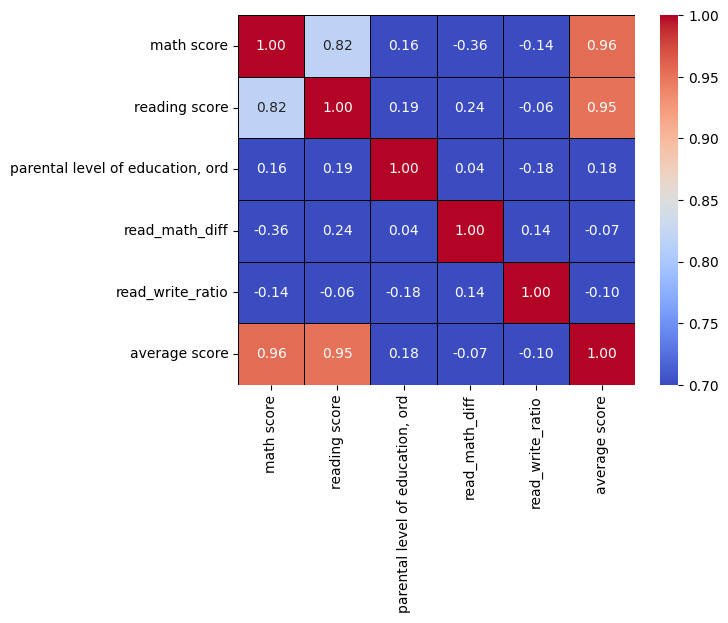

In [146]:
sns.heatmap(
    df[numeric_features].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0.7,
    vmax=1,
    linewidths=0.5,
    linecolor='black'
)

In [153]:
# 8. Preprocessing pipeline
X = df[features]
y = df['writing score']


preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical)
])
X.head()

,math score,reading score,"parental level of education, ord",read_math_diff,read_write_ratio,average score,gender,race/ethnicity,lunch,test preparation course
0,72,72,4,0,0.960000,72.0,female,group B,standard,none
1,69,90,2,21,1.011236,79.5,female,group C,standard,completed
2,90,95,5,5,1.010638,92.5,female,group B,standard,none
3,47,57,3,10,1.266667,52.0,male,group A,free/reduced,none
4,76,78,2,2,1.026316,77.0,male,group C,standard,none


In [154]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [155]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 10), (200, 10), (800,), (200,))

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=random_state),
    'Random Forest': RandomForestRegressor(random_state=random_state),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}
results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse = np.sqrt(-scores)
    results[name] = rmse.mean()

print("Cross-validated RMSE on training set:")
for name, rmse in results.items():
    print(f"{name}: {rmse:.2f}")

Cross-validated RMSE on training set:
Linear Regression: 1.11
Decision Tree: 1.40
Random Forest: 1.13


In [ ]:
# 11. Hyperparameter tuning for Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])
param_grid = {
    'model__n_estimators': range(50, 200, 25),
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest parameters for Random Forest:")
display(grid_search.best_params_)
print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.2f}")


Best parameters for Random Forest:


{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 75}

Best CV RMSE: 1.13
